In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy
import control
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from ssm_stats import EsmssmStats
stats = EsmssmStats()
from ssm_plotting import EsmssmPlotting
plotting = EsmssmPlotting()

# Define filepath
filepath = '../../results/modelfits/'

# Define path to save figures
figpath = '../../results/paper_figures/'
savefig = False

In [2]:
# Leemput simulated data and re-estimated data
rec_raw = mat73.loadmat(filepath + 'leemput/recovery.mat')
rec = deepcopy(rec_raw)
Nsj = len(rec['recovery'])
iterations = len(rec['recovery'][0]['est'])

In [3]:
# Twindata simulated data and re-estimated data
rec_raw_input = mat73.loadmat(filepath + 'twindata/recovery_inp.mat')
rec_input = deepcopy(rec_raw_input)
Nsj_inp = len(rec_input['recovery'])
iterations_inp = len(rec['recovery'][0]['est'])

In [4]:
# Extract recovery data from mat file
def extract_recovery(rec, input_exist):
    Nsj = len(rec['recovery'])
    iterations = len(rec['recovery'][0]['est'])
    m, n = np.shape(rec['recovery'][0]['true'][0]['A'])
    recovery = {'true': {'A': np.full((m,m,Nsj), np.nan), \
                         'val': np.full((m,Nsj), np.nan), \
                         'vec': np.full((m,m,Nsj), np.nan), \
                         'bias': np.full((m,Nsj), np.nan)}, 
                'est': {'A': np.full((m,m,Nsj,iterations), np.nan), \
                        'val': np.full((m,Nsj,iterations), np.nan), \
                        'vec': np.full((m,m,Nsj,iterations), np.nan), \
                        'bias': np.full((m,Nsj,iterations), np.nan)}}
    if input_exist:
        recovery['true']['conval'] =  np.full((m,Nsj), np.nan)
        recovery['true']['convec'] =  np.full((m,m,Nsj), np.nan)
        recovery['est']['conval'] =  np.full((m,Nsj,iterations), np.nan)
        recovery['est']['convec'] =  np.full((m,m,Nsj,iterations), np.nan)
     
    ll=[]
    for i in range(Nsj):
        recovery['true']['A'][:,:,i] = (rec['recovery'][i]['true'][0]['A'] + rec['recovery'][i]['true'][0]['W'])
        e,v = stats.eig_dynamics_features(rec['recovery'][i]['true'][0]['A'] + rec['recovery'][i]['true'][0]['W'])
        recovery['true']['val'][:,i] = np.real(e)
        recovery['true']['vec'][:,:,i] = np.real(v)
        recovery['true']['bias'][:,i] = rec['recovery'][i]['true'][0]['h']

        if input_exist:
            s,u = stats.svd_control_features(rec['recovery'][i]['true'][0]['A']+rec['recovery'][i]['true'][0]['W'], \
                                       rec['recovery'][i]['true'][0]['C'])
            recovery['true']['conval'][:,i] = np.real(s)
            recovery['true']['convec'][:,:,i] = np.real(u)
        
        for r in range(iterations):
                recovery['est']['A'][:,:,i,r] = (rec['recovery'][i]['est'][r]['A'] + rec['recovery'][i]['est'][r]['W'])
                [e, v]= stats.eig_dynamics_features(rec['recovery'][i]['est'][r]['A'] + rec['recovery'][i]['est'][r]['W'])
                recovery['est']['val'][:,i,r] = np.real(e)
                recovery['est']['vec'][:,:,i,r] = np.real(v)
                recovery['est']['bias'][:,i,r] = rec['recovery'][i]['est'][r]['h']

                if input_exist:
                    s,u = stats.svd_control_features(rec['recovery'][i]['est'][r]['A'] + rec['recovery'][i]['est'][r]['W'], \
                                               rec['recovery'][i]['est'][r]['C'])
                    recovery['est']['conval'][:,i,r] = np.real(s)
                    recovery['est']['convec'][:,:,i,r] = np.real(u)
        
    return recovery

In [5]:
# Leemput recovery without inputs
recovery = extract_recovery(rec, False)

In [6]:
# Twinsscan recovery with inputs
recovery_inp = extract_recovery(rec_input, True)

In [7]:
def extract_recovery_features_for_plot(recovery):

    m, n, Nsj, r = np.shape(recovery['est']['A'])

    rec_plot = dict()
    rec_plot['dot_product'] = np.full((4,Nsj,iterations), np.nan)
    rec_plot['eigval_correlation'] = np.full((m,iterations), np.nan)
    rec_plot['eigvec_correlation'] = np.full((m,m,iterations), np.nan)
    rec_plot['matrix_correlation'] = np.full((m,m,iterations), np.nan)
    rec_plot['rmse_A'] = np.full((m,m,iterations), np.nan)
    rec_plot['bias_correlation'] = np.full((m,iterations), np.nan)

    if 'conval' in recovery['true'].keys():
        rec_plot['dot_product_control'] = np.full((4,Nsj,iterations), np.nan)
        rec_plot['conval_correlation'] = np.full((m,iterations), np.nan)
        rec_plot['convec_correlation'] = np.full((m,m,iterations), np.nan)
        
    for r in range(r):
        for i in range(Nsj):
            rec_plot['dot_product'][:,i,r] = np.abs(np.diag(recovery['true']['vec'][:,:,i].T \
                                                    @ recovery['est']['vec'][:,:,i,r]))
            if 'conval' in recovery['true'].keys():
                rec_plot['dot_product_control'][:,i,r] = np.abs(np.diag(recovery_inp['true']['convec'][:,:,i].T \
                                                    @ recovery_inp['est']['convec'][:,:,i,r]))
                
            nanidx = np.isnan(recovery['est']['val'][0,:,r])
            for i in range(m):
                for j in range(m):
                    rec_plot['matrix_correlation'][i,j,r] = scipy.stats.spearmanr(recovery['true']['A'][i,j,~nanidx], \
                                                            recovery['est']['A'][i,j,~nanidx,r])[0]
                    rec_plot['rmse_A'][i,j,r] = np.sqrt(np.mean((recovery['true']['A'][i,j,~nanidx] - \
                                                     recovery['est']['A'][i,j,~nanidx,r])**2))
                    rec_plot['eigval_correlation'][i,r] = scipy.stats.spearmanr(recovery['true']['val'][i,~nanidx], \
                                                        recovery['est']['val'][i,~nanidx,r])[0]
                    rec_plot['eigvec_correlation'][i,j,r] = scipy.stats.spearmanr(np.abs(recovery['true']['vec'][i,j,~nanidx]), \
                                                            np.abs(recovery['est']['vec'][i,j,~nanidx,r]))[0]
                    rec_plot['bias_correlation'][i,r] = scipy.stats.spearmanr(recovery['true']['bias'][i,~nanidx], \
                                                        recovery['est']['bias'][i,~nanidx,r])[0]
                    if 'conval' in recovery['true'].keys():
                        rec_plot['conval_correlation'][i,r] = scipy.stats.spearmanr(recovery_inp['true']['conval'][i,~nanidx], \
                                                    recovery_inp['est']['conval'][i,~nanidx,r])[0]
                        rec_plot['convec_correlation'][i,j,r] = scipy.stats.spearmanr(np.abs(recovery_inp['true']['convec'][i,j,~nanidx]), \
                                                        np.abs(recovery_inp['est']['convec'][i,j,~nanidx,r]))[0]
    return rec_plot

In [8]:
# Recovery features without inputs
rec_plot = extract_recovery_features_for_plot(recovery)

In [9]:
# Outlier detection based on loglikelihood in dataset with inputs
ll = []
for i in range(Nsj_inp):
    for r in range(iterations_inp):
        ll.append(rec_input['recovery'][i]['est'][r]['LL'][-1])
        
ex = stats.detect_ll_outlier(np.reshape(np.array(ll),(Nsj_inp,iterations_inp)))
for i in range(len(ex[0])):
        rec_input['recovery'][ex[0][i]]['est'][ex[1][i]] = []

# Recovery features with inputs
rec_inp_plot = extract_recovery_features_for_plot(recovery_inp)

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_58718/4073271786.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


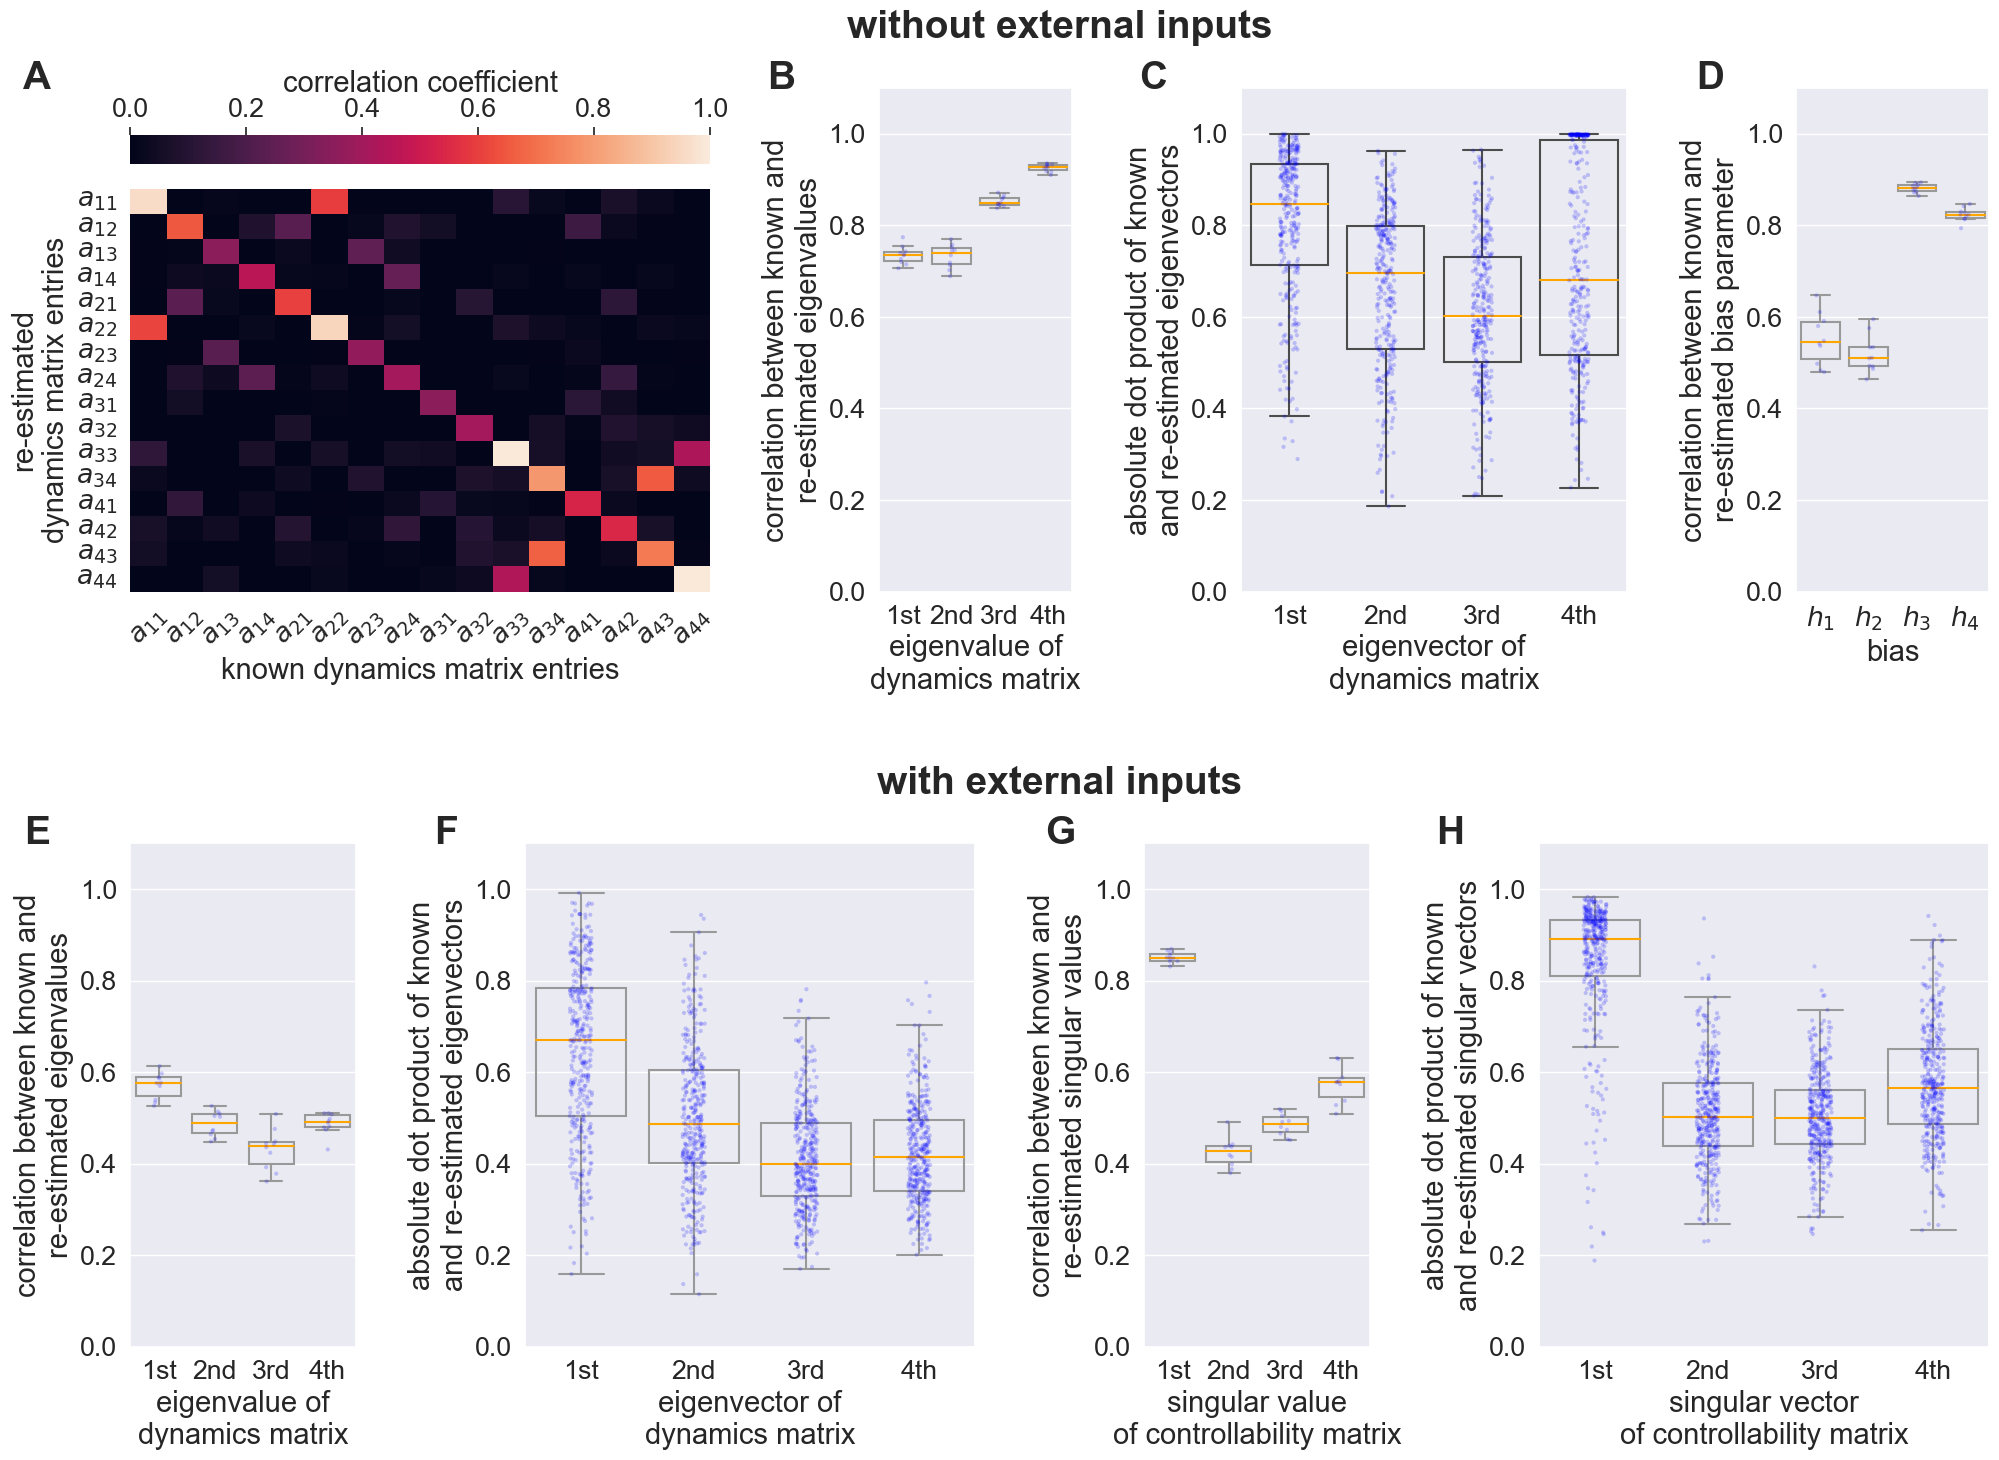

In [11]:
# Recovery plot
mood_columns = ['cheerful', 'content', 'anxious', 'sad']

sns.set(font_scale=1.75)
fig = plt.figure(figsize=(20, 14))

outer = gridspec.GridSpec(2, 1, hspace=0.5)
inner = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0], wspace=0.5, width_ratios=[6,2,4,2])

# Plot heatmap of correlation matrix between known and re-estimated A matrix
corr_A = []
for i in range(len(rec['recovery'][0]['est'])):
    corr_A.append(np.corrcoef(recovery['true']['A'].reshape(16, Nsj), \
                              recovery['est']['A'][:,:,:,i].reshape(16, Nsj))[16:,:16])
    
ax = fig.add_subplot(inner[0,0])
sns.heatmap(np.nanmean(np.array(corr_A),0),vmin=0, vmax=1, \
            yticklabels=['$a_{' + str(i+1) + str(j+1) + '}$' for i in range(4) for j in range(4)], \
            xticklabels=['$a_{' + str(i+1) + str(j+1) + '}$' for i in range(4) for j in range(4)], ax=ax, \
           cbar_kws={'label': 'correlation coefficient', 'location':"top"})
ax.set_yticklabels(['$a_{' + str(i+1) + str(j+1) + '}$' for i in range(4) for j in range(4)])
ax.set_xticklabels(['$a_{' + str(i+1) + str(j+1) + '}$' for i in range(4) for j in range(4)], rotation=45)
ax.set_ylabel('re-estimated\ndynamics matrix entries')
ax.set_xlabel('known dynamics matrix entries')

# Plot boxplot of correlation between known and re-estimated eigenvalues of the A matrix
ax = fig.add_subplot(inner[0,1])
sns.boxplot(data=rec_plot['eigval_correlation'].T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=rec_plot['eigval_correlation'].T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('eigenvalue of\ndynamics matrix')
ax.set_ylabel('correlation between known and\nre-estimated eigenvalues')
ax.set_ylim([0,1.1])

# Plot boxplot of absolut dotproduct between known and re-estimated eigenvectors of the A matrix
ax = fig.add_subplot(inner[0,2])
b = sns.boxplot(data=np.nanmean(rec_plot['dot_product'],axis=2).T, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), ax=ax, showfliers = False)
sns.stripplot(data=np.nanmean(rec_plot['dot_product'],axis=2).T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('eigenvector of\ndynamics matrix')
ax.set_ylabel('absolute dot product of known\nand re-estimated eigenvectors')
ax.set_ylim([0,1.1])

# Plot boxplot of correlation between known and re-estimated bias
ax = fig.add_subplot(inner[0,3])
sns.boxplot(data=rec_plot['bias_correlation'].T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=rec_plot['bias_correlation'].T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['$h_' + str(i)+'$' for i in range(1,5)])
ax.set_ylabel('correlation between known and\nre-estimated bias parameter')
ax.set_xlabel('bias')
ax.set_ylim([0,1.1])

inner = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[1], wspace=0.5, width_ratios=[2,4,2,4])

#  Plot boxplot of correlation between known and re-estimated eigenvalues of the A matrix
ax = fig.add_subplot(inner[0,0])
sns.boxplot(data=rec_inp_plot['eigval_correlation'].T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=rec_inp_plot['eigval_correlation'].T, size=3, color='blue', alpha=0.2, ax = ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('eigenvalue of\ndynamics matrix')
ax.set_ylabel('correlation between known and\nre-estimated eigenvalues')
ax.set_ylim([0,1.1])

#  Plot boxplot of absolut dotproduct between known and re-estimated eigenvectors of the A matrix
ax = fig.add_subplot(inner[0,1])
b = sns.boxplot(data=np.nanmean(rec_inp_plot['dot_product'],axis=2).T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=np.nanmean(rec_inp_plot['dot_product'],axis=2).T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('eigenvector of\ndynamics matrix')
ax.set_ylabel('absolute dot product of known\nand re-estimated eigenvectors')
ax.set_ylim([0,1.1])

#  Plot boxplot of correlation between known and re-estimated singular values of the C matrix
ax = fig.add_subplot(inner[0,2])
sns.boxplot(data=rec_inp_plot['conval_correlation'].T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=rec_inp_plot['conval_correlation'].T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('singular value\nof controllability matrix')
ax.set_ylabel('correlation between known and\nre-estimated singular values')
ax.set_ylim([0,1.1])

#  Plot boxplot of absolut dotproduct between known and re-estimated eigenvectors of the C matrix
ax = fig.add_subplot(inner[0,3])
b = sns.boxplot(data=np.nanmean(rec_inp_plot['dot_product_control'],axis=2).T, color='white', ax=ax, boxprops=dict(facecolor=(0,0,0,0)), \
                medianprops=dict(color="orange"), showfliers = False)
sns.stripplot(data=np.nanmean(rec_inp_plot['dot_product_control'],axis=2).T, size=3, color='blue', alpha=0.2, ax=ax)
ax.set_xticks(range(4), ['1st', '2nd', '3rd', '4th'])
ax.set_xlabel('singular vector\nof controllability matrix')
ax.set_ylabel('absolute dot product of known\nand re-estimated singular vectors')
ax.set_ylim([0,1.1])
            
grid = plt.GridSpec(2, 4)
for i,j in enumerate(['A', 'B','C','D']):
    plotting.create_subtitle(fig, grid[0, ::], j, [-0.05, 0.35, 0.55, 0.85][i], 0.9)
    
plotting.create_subtitle(fig, grid[0, ::], 'without external inputs', 0.5, 1)

for i,j in enumerate(['E', 'F','G','H']):
    plotting.create_subtitle(fig, grid[1, ::], j, [-0.05, 0.17, 0.5, 0.71][i], 0.9)
    
plotting.create_subtitle(fig, grid[1, ::], 'with external inputs', 0.5, 1)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
if savefig: plt.savefig(figpath + 'malamud_fig3_recovery.svg', bbox_inches='tight')